In [2]:
## Load modules
import tensorflow as tf
from tensorflow.python.framework import ops
import numpy as np
from numpy import genfromtxt
import matplotlib.pyplot as plt
%matplotlib inline
import os
cwd = os.getcwd() # current working directory

In [3]:
import sys
sys.path.append(os.path.abspath(cwd))

In [4]:
## Load data
#data_dir = "cycle_10bins_conditions_none"#"2sec_data_avg" # name of the data folder

# Loading the train, dev, test data from specified folder
#os.chdir(cwd+"/"+data_dir+"/train")
#x_train = genfromtxt("x_train.csv", delimiter=',')
#y_train = genfromtxt("y_train.csv", delimiter=',')

In [5]:
# data (num_samples, features)
basedir = '/Users/Mike/Dropbox/Research/Stanford/Lele/AWS_2016-06_Multi-Height_Time_Series/'
windFile = 'Firewheel_FWL'+str(1)+'_mast_file_tsec_72-months.csv'
def importWindFile(basedir, windFile):
    data = np.loadtxt(basedir+windFile, delimiter=',', skiprows=7)
    ws = np.zeros((data.shape[0],5))
    time = np.linspace(0., 10.*data.shape[0],data.shape[0])
    nt = ws.shape[0]
    hour = data[:,3]
    month = data[:,1]
    for i  in range(0,5):
        ind = 5*(i+1)
        ws[:,i] = data[:,ind]
    return ws, hour, time, nt, month
ws, hour, time, nt, month = importWindFile(basedir, windFile)


In [37]:
# Full dataset
Nt = ws.shape[0]
# Physical parameters
horizon = 18
dataHeight = 0 # index of the height we want
# Initialize
xFull = np.zeros((horizon-1,Nt))
yFull = np.zeros((Nt,1))
for i in range(horizon,Nt):
    xFull[:,i-horizon] = ws[i-horizon:i-1,dataHeight]
    yFull[i-horizon] = ws[i,dataHeight]
# Select the dev set
randomSeed = int(np.round(np.random.rand(1)*Nt))
n_dev = int(np.round(Nt*0.01)) # use 1% of the data for dev
x_dev = xFull[:,randomSeed:randomSeed+n_dev]
y_dev = yFull[randomSeed:randomSeed+n_dev]
x_dev = x_dev.T
# Set the test data as the rest of it
x_train = np.append(xFull[:,0:randomSeed-1],xFull[:,randomSeed+n_dev+1:Nt],axis=1)
y_train = np.append(yFull[0:randomSeed-1],yFull[randomSeed+n_dev+1:Nt],axis=0)
x_train = x_train.T
print(x_train.shape)
print(x_dev.shape)

(312347, 17)
(3155, 17)


In [38]:
# Train set
#nt = 1000
#horizon = 18
#n_train = nt-horizon
#x_train = np.zeros((horizon-1,n_train))
#y_train = np.zeros((n_train,1))
#dataHeight = 0 # index of the height we want
#for i in range(horizon,nt):
#    x_train[:,i-horizon] = ws[i-horizon:i-1,dataHeight]
#    y_train[i-horizon] = ws[i,dataHeight]
#x_train = x_train.T
# Dev set
#randomSeed = 180 # days in the future from the train set
#randomSeed = randomSeed*24*6 # dev is some amount of day in the future
#nd = 100
#n_dev = nd-horizon
#x_dev = np.zeros((horizon-1,n_dev))
#y_dev = np.zeros((n_dev,1))
#for i in range(horizon,nd):
#    x_dev[:,i-horizon] = ws[randomSeed+i-horizon:randomSeed+i-1,dataHeight]
#    y_dev[i-horizon] = ws[randomSeed+i,dataHeight]
#x_dev = x_dev.T

In [39]:
#print(x_all.shape)
#x_train = x_all[10:110,10:20] # (100,10)
data_size, features = x_train.shape

In [40]:
def normalize_data(data):
    mu = np.mean(data,axis=0) # compute the mean along axis = 0 (num_samples for raw data)
    cov = np.std(data,axis=0) # using std instead of variance seems to be best
    return mu, cov # returning the normalizations for the data

x_mu, x_cov = normalize_data(x_train) # x_train is (features x num_samples)
y_mu, y_cov = normalize_data(y_train) # x_train is (features x num_samples)

#y_mu, y_cov = normalize_data(y_train)

X_train = ((x_train - x_mu)/x_cov).T # still in (features, data_samples)
Y_train = np.squeeze(y_train)
X_dev = ((x_dev - x_mu)/x_cov).T # still in (features, data_samples)
Y_dev = np.squeeze(y_dev)
print(X_train.shape)
print(Y_train.shape)

(17, 312347)
(312347,)


In [41]:
def initialize_parameters(num_hid_layers, size_hid_layers, n_x, output_size):
    parameters = {}
    total_layers = num_hid_layers+1
    
    for l in range(1,total_layers+1):
        if l == 1:
            a = size_hid_layers
            b = n_x
        elif l == total_layers:
            a = output_size
            b = size_hid_layers
        else:
            a = size_hid_layers
            b = size_hid_layers
            
        parameters['w' + str(l)] = tf.get_variable('w'+str(l), [a, b], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
        parameters['b' + str(l)] = tf.get_variable('b'+str(l), [a,1], initializer = tf.zeros_initializer())    
    return parameters

In [42]:
def forward_prop(X,parameters):
    total_layers = len(parameters)//2
    layer_outputs = {}
    layer_outputs['A0'] = X
    
    for l in range(1,total_layers+1):
        layer_outputs['Z' + str(l)] = tf.matmul(parameters['w' + str(l)],layer_outputs['A' + str(l-1)])+parameters['b' + str(l)]
        layer_outputs['A' + str(l)] = tf.nn.relu(layer_outputs['Z' + str(l)])
        #layer_outputs['A' + str(l)] = tf.nn.dropout(layer_outputs['A' + str(l)],keep_prob)
    
    return layer_outputs['Z' + str(total_layers)]

In [61]:
def model(X_train, Y_train, X_dev, Y_dev, learning_rate, num_epochs, num_hid_layers, size_hid_layers, minibatch_size, print_interval=10,plotting = True):

    ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
    tf.set_random_seed(1)                             # to keep consistent results
    (n_x, m) = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
    n_y = Y_train.shape[0]                            # n_y : output size
    losses = []                                        # To keep track of the cost
    train_errs = []                                        # To keep track of the cost
    dev_errs = []                                        # To keep track of the cost
    eps = 10**-8.
    
    O = 1 # output size?
    
    X = tf.placeholder(tf.float32,[n_x,None])
    Y = tf.placeholder(tf.float32,[None])
    
    parameters = initialize_parameters(num_hid_layers, size_hid_layers, n_x, O)
    out = forward_prop(X, parameters)
    
    #loss = tf.reduce_mean(tf.squared_difference(out, Y)) # L2 loss --> not good for our problem
    loss = tf.reduce_mean(tf.losses.absolute_difference(Y,tf.squeeze(out))) # L1 loss
    
    optimizer = tf.train.AdamOptimizer(learning_rate).minimize(loss) # Optimizer, change the learning rate here

    init = tf.global_variables_initializer() # When init is run later (session.run(init)),
    with tf.Session() as sess: # starting tf session --> all computation on tf graph in this with struct
        sess.run(init)
        for epoch in range(num_epochs+1):
            _, loss_val = sess.run([optimizer, loss], feed_dict={X: X_train, Y: Y_train})
            losses.append(loss_val)
            if epoch % (num_epochs/print_interval) == 0:
                print("Loss: ",loss_val)
                # Output the predictions
                train_pred = sess.run(out, feed_dict={X: X_train})
                dev_pred = sess.run(out, feed_dict={X: X_dev})
                train_pred = np.squeeze(train_pred)
                train_err = np.mean(np.divide(abs(train_pred - Y_train),Y_train+eps)) # absolute error
                dev_err = np.mean(np.divide(abs(dev_pred - Y_dev),Y_dev+eps))
                train_errs.append(train_err)
                dev_errs.append(dev_err)
        print('Train error: ', train_err)
        print('Dev error: ', dev_err)
        if plotting:
            # Plot percent errors during iterations
            fig = plt.figure(num=None, dpi=200, facecolor='w', edgecolor='k'); ax = plt.gca()
            plt.plot(np.squeeze(train_errs))
            ax.set_yscale('log')
            plt.ylabel('Percent error')
            plt.title("Error for learning rate = " + str(learning_rate))
            plt.show()
     
    
    results = train_errs, Y_train, train_pred, Y_dev, dev_pred, dev_errs
    return results

In [62]:
learning_rate = 0.005#0.0005
num_epochs = 100 # total number of epochs to iterate through
print_interval = 10 # number of prints per total run
minibatch_size = 10
num_hid_layers = 2
size_hid_layers = 128

results=model(X_train, Y_train, X_dev, Y_dev, learning_rate, num_epochs, num_hid_layers, size_hid_layers, minibatch_size, print_interval, plotting=False)

('Loss: ', 8.6400585)
('Loss: ', 4.399622)
('Loss: ', 2.7987719)
('Loss: ', 1.7329661)
('Loss: ', 1.137432)
('Loss: ', 0.92698765)
('Loss: ', 0.86763221)
('Loss: ', 0.84701288)
('Loss: ', 0.83729422)
('Loss: ', 0.83214086)
('Loss: ', 0.82880604)
('Train error: ', 5403.2665025680317)
('Dev error: ', 0.15330439786239258)


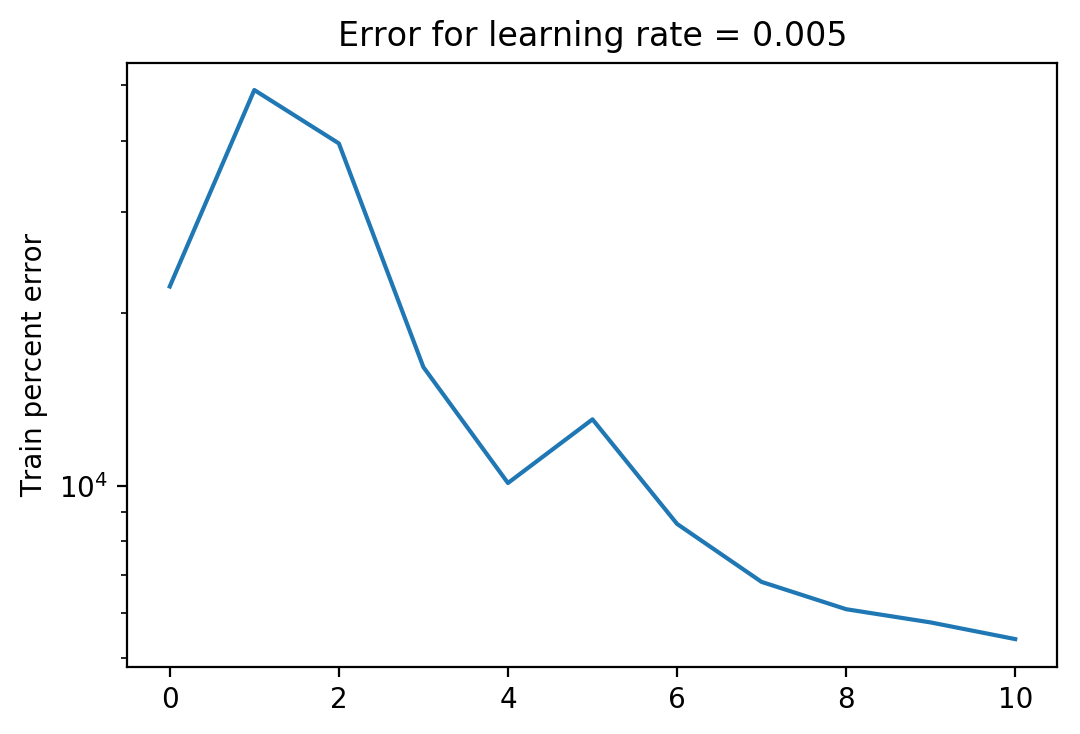

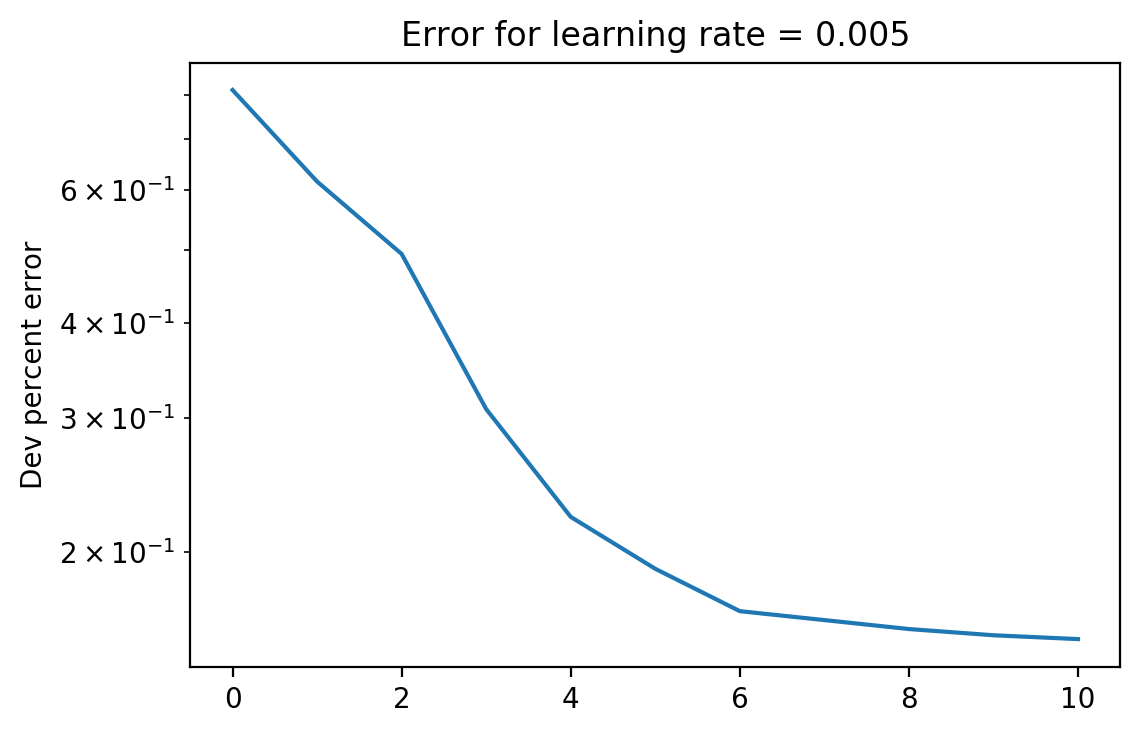

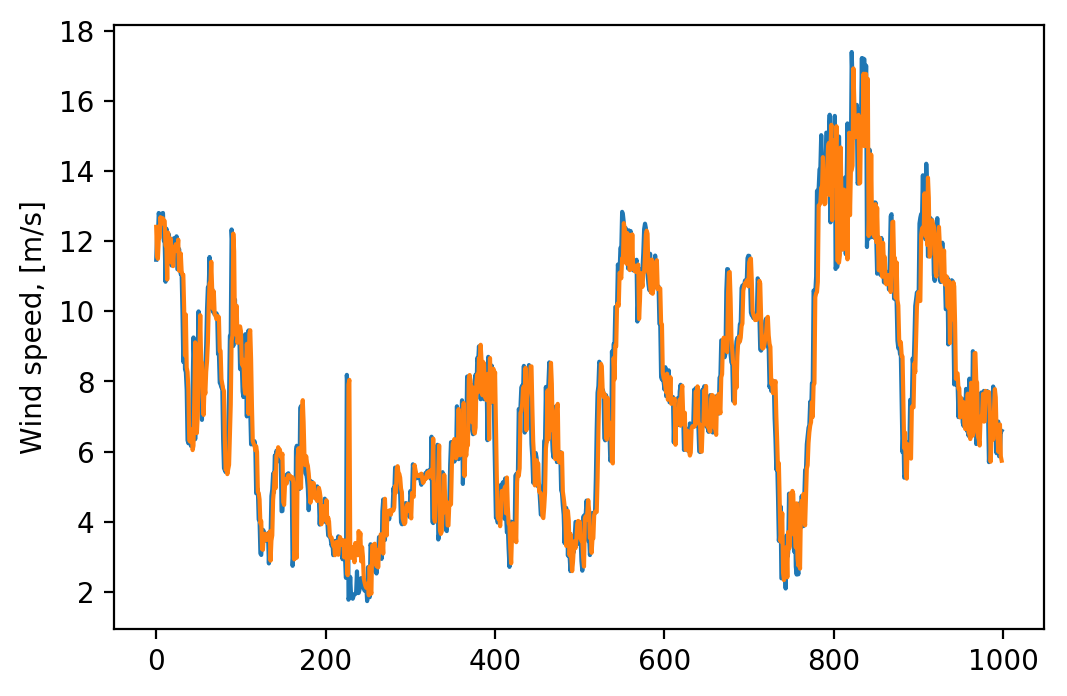

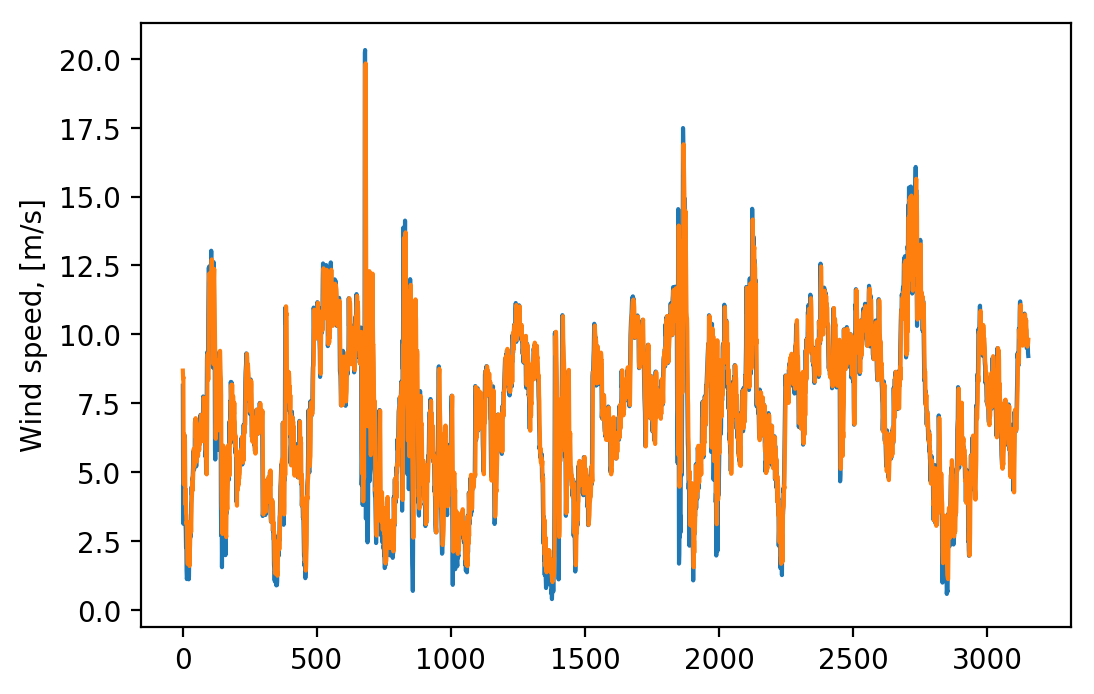

In [57]:
## Plot Results
# Train error
train_err = results[0]
fig = plt.figure(num=None, dpi=200, facecolor='w', edgecolor='k'); ax = plt.gca()
plt.plot(np.squeeze(train_err))
ax.set_yscale('log')
plt.ylabel('Train percent error')
plt.title("Error for learning rate = " + str(learning_rate))
plt.show()
# Dev error
dev_err = results[5]
fig = plt.figure(num=None, dpi=200, facecolor='w', edgecolor='k'); ax = plt.gca()
plt.plot(np.squeeze(dev_err))
ax.set_yscale('log')
plt.ylabel('Dev percent error')
plt.title("Error for learning rate = " + str(learning_rate))
plt.show()
# Predictions vs train
Y_train = results[1]
Y_pred = results[2]
fig = plt.figure(num=None, dpi=200, facecolor='w', edgecolor='k'); ax = plt.gca()
plt.plot(np.squeeze(Y_train[1:1000]))
plt.plot(np.squeeze(Y_pred[1:1000]))
plt.ylabel('Wind speed, [m/s]')
plt.show()
# Predictions vs dev
Y_dev = results[3]
dev_pred = results[4]
fig = plt.figure(num=None, dpi=200, facecolor='w', edgecolor='k'); ax = plt.gca()
plt.plot(np.squeeze(Y_dev))
plt.plot(np.squeeze(dev_pred))
plt.ylabel('Wind speed, [m/s]')
plt.show()

In [ ]:
print(train_err)

In [ ]:
# Does creating a log file in each call to the model function mess up the main log file?

def hyperparamSearch(X_train, Y_train, X_dev, Y_dev, X_test, Y_test, lr_rng, num_hid_layers_rng, beta_rng, k_p_rng, reg_type,
                     size_hid_layers_rng, num_sims, num_epochs, minibatch_size, log_dir, parallel=False, cores=1):
    # compute random values within the ranges for each param of length num_sims
    num_features, data_length = X_train.shape 
    num_params = 5
    np.random.seed(13) # set seed for rand
    lower_bounds = [lr_rng[0],num_hid_layers_rng[0],size_hid_layers_rng[0],beta_rng[0],k_p_rng[0]]
    upper_bounds = [lr_rng[1],num_hid_layers_rng[1],size_hid_layers_rng[1],beta_rng[1],k_p_rng[1]]
    sample_size = [num_sims, num_params] # num_sims x number of params in search
    samples_params = np.random.uniform(lower_bounds, upper_bounds, sample_size)

    # modifying the initial random parameters
    lr_samples = 10**samples_params[:,0] # log scale
    hl_samples = samples_params[:,1].astype(int) # rounded down to nearest int
    hu_samples = (samples_params[:,2]*num_features).astype(int) # base of 10 neurons used for each level
    beta = samples_params[:,3]
    k_p = samples_params[:,4]
    
    # save the data for the ranges used to the main sim file
    utils.logging.info("lr_rng = "+str(lr_rng)+" hidden layers rng = "+str(num_hid_layers_rng)+" hidden units rng = "+str(size_hid_layers_rng)+" num sims = %d", num_sims)
    
    results = [0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]
    
    if parallel: # Need cores 
        print("parallelizing the training") # add parallel ability for specified number of cores similar to funct above
        results = multi_sim(X_train, Y_train, X_dev, Y_dev, X_test, Y_test, lr_samples, beta, k_p, reg_type,
                            num_epochs, hl_samples, hu_samples, minibatch_size, log_dir, True, False, 10, 
                            100, True, cores)
        print(results)
    else:
        for i in range(len(lr_samples)):
            train_err, dev_err, test_err, min_dev, min_epoch = model(X_train, Y_train, X_dev, Y_dev, X_test, Y_test, lr_samples[i], beta[i], k_p[i], reg_type,
                                                                 num_epochs, hl_samples[i], hu_samples[i], minibatch_size, 
                                                                log_dir, False, False, 10, 100, False, 0) # call model funct
            temp_results = np.array([lr_samples[i], hl_samples[i], hu_samples[i], beta[i], k_p[i], num_epochs, train_err, dev_err, test_err, min_epoch, min_dev])
            #utils.set_logger(os.path.join(cwd+"/"+log_dir,log_dir+'.log')) # reset logger to main log file
            utils.logging.info("START OF NEW MODEL")
            utils.logging.info("learning rate = %f, hidden layers = %d, hidden units = %d, beta = %f, keep_prob = %f, epochs = %d, reg_type = %s", lr_samples[i], hl_samples[i], hu_samples[i], beta[i], k_p[i], num_epochs, reg_type) # add other hyperparams
            utils.logging.info("Train Err = %f, Dev Err = %f, Test Err = %f, Min Dev Err = %f, Min Epoch = %d", train_err, dev_err, test_err, min_dev, min_epoch) # add other hyperparams
            results = np.vstack((results,temp_results))# get all results in a list
        
        # results contain an array of the parameters and then the resulting errors
        results = results[1:,:] # get rid of placeholder row
        results= results[results[:,-1].argsort()] # sort by the lowest dev error
        utils.logging.info("RESULTS")
        utils.logging.info(str(results))
    return results